In [1]:
import pandas as pd
from nlpia.data.loaders import get_data
pd.options.display.width = 120  # <1>

sms = get_data('sms-spam')
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)]  # <2>
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)
mask = sms.spam.astype(bool).values
sms['spam'] = sms.spam.astype(int)

d:\users\50477\appdata\local\programs\python\python38\lib\site-packages\pugnlp\constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
d:\users\50477\appdata\local\programs\python\python38\lib\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
d:\users\50477\appdata\local\programs\python\python38\lib\site-packages\pugnlp\tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
d:\users\50477\appdata\local\programs\python\python38\lib\site-packages\pugnlp\util.py:80: FutureWarning: The pandas.np module is deprecated and will

In [2]:
sms.head(6)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...


In [3]:
#进行TF-IDF词向量分解
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()
print(tfidf_docs.shape)#文章-词向量形状
print(sms.spam.sum())#垃圾文章个数

(4837, 9232)
638


In [4]:
mask = sms.spam.astype(bool).values  # <1>
spam_centroid = tfidf_docs[mask].mean(axis=0) # 垃圾质心
ham_centroid = tfidf_docs[~mask].mean(axis=0) #非垃圾质心

In [5]:
spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid) 
#spam_centroid - ham_centroid为分类线tfidf_docs*(spam_centroid - ham_centroid)为投影


from sklearn.preprocessing import MinMaxScaler
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))
sms['lda_predict'] = (sms.lda_score > .5).astype(int) #进行归一化并通过0.5来分类
(1.-(sms.spam-sms.lda_predict).abs().sum()/len(sms)).round(3) #0.977被正确分类

0.977

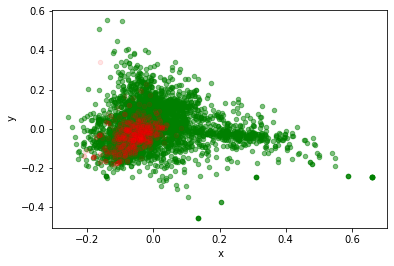

In [6]:
#本例的2D图
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn
pca_model = PCA(n_components=3)
tfidf_docs_3d = pca_model.fit_transform(tfidf_docs)
df = pd.DataFrame(tfidf_docs_3d)
ax = df[~mask].plot(x=0, y=1, kind='scatter', alpha=.5, c='green')
df[mask].plot(x=0, y=1, ax=ax, alpha=.1, kind='scatter', c='red')
plt.xlabel(' x')
plt.ylabel(' y')
plt.savefig('spam_lda_2d_scatter.png')


In [7]:
#本例的3D图.由于图存成文件太大,都给删除了.jupyter产生的结果也会被删除
import plotly as py
spam_trace = dict(
        x=df[0][mask], y=df[1][mask], z=df[2][mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='red', line=dict(width=0)) 
    )
ham_trace = dict(
        x=df[0][~mask], y=df[1][~mask], z=df[2][~mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='green', line=dict(width=0)) 
    )
fig = dict(data=[ham_trace, spam_trace], layout={'title': 'LDA Spamminess Model'})
py.offline.plot(fig, filename='lda_spam_3d_scatter.html')

'lda_spam_3d_scatter.html'